## Notebook setup

In [1]:
# dependencies

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from numpy import sqrt

from sklearn.model_selection import train_test_split
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.api import Holt 
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller


In [2]:
#reading data from file
train = pd.read_csv(r'C:/Testing/DA/predictFutureSalesClean.csv')
test = pd.read_csv('C:/Testing/DA/test.csv')
sample_submission = pd.read_csv('C:/Testing/DA/sample_submission.csv')
items = pd.read_csv('C:/Testing/DA/items.csv')
item_cats = pd.read_csv('C:/Testing/DA/item_categories.csv')
shops = pd.read_csv('C:/Testing/DA/shops.csv')

In [3]:
#checking the data types of train
train.dtypes

Unnamed: 0              int64
date                   object
date_block_num          int64
shop_id                 int64
item_id                 int64
item_price            float64
item_cnt_day          float64
shop_name              object
item_name              object
item_category_id        int64
Required                 bool
item_category_name     object
date_month              int64
date_year               int64
total_sales           float64
dtype: object

## 2. Feature Engineering 

### 2.1 Lag Features

A lag value of 7 is being chosen to correlate of weekly trend

In [49]:
#lag feature - to be used as the bases for machine learning

all_data_by_day = all_data
aggregations = {'total_sales':'sum'}
all_data_by_day = all_data_by_day.groupby(['date'], as_index=False).agg(aggregations)
all_data_by_day['lag_1'] = all_data_by_day['total_sales'].shift(1)
all_data_by_day['lag_2'] = all_data_by_day['total_sales'].shift(2)
all_data_by_day['lag_3'] = all_data_by_day['total_sales'].shift(3)
all_data_by_day['lag_4'] = all_data_by_day['total_sales'].shift(4)
all_data_by_day['lag_5'] = all_data_by_day['total_sales'].shift(5)
all_data_by_day['lag_6'] = all_data_by_day['total_sales'].shift(6)
all_data_by_day['lag_7'] = all_data_by_day['total_sales'].shift(7)
all_data_by_day

,date,total_sales,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
0,2013-01-01,"286,396",nan,nan,nan,nan,nan,nan,nan
1,2013-01-02,"1,258,655","286,396",nan,nan,nan,nan,nan,nan
2,2013-01-03,"1,131,019","1,258,655","286,396",nan,nan,nan,nan,nan
3,2013-01-04,"965,669","1,131,019","1,258,655","286,396",nan,nan,nan,nan
4,2013-01-05,"955,023","965,669","1,131,019","1,258,655","286,396",nan,nan,nan
...,...,...,...,...,...,...,...,...,...
1029,2015-10-27,"2,211,635","1,882,246","3,412,849","4,040,446","6,107,958","2,480,586","2,289,480","2,659,224"
1030,2015-10-28,"1,696,390","2,211,635","1,882,246","3,412,849","4,040,446","6,107,958","2,480,586","2,289,480"
1031,2015-10-29,"1,822,707","1,696,390","2,211,635","1,882,246","3,412,849","4,040,446","6,107,958","2,480,586"
1032,2015-10-30,"2,551,906","1,822,707","1,696,390","2,211,635","1,882,246","3,412,849","4,040,446","6,107,958"


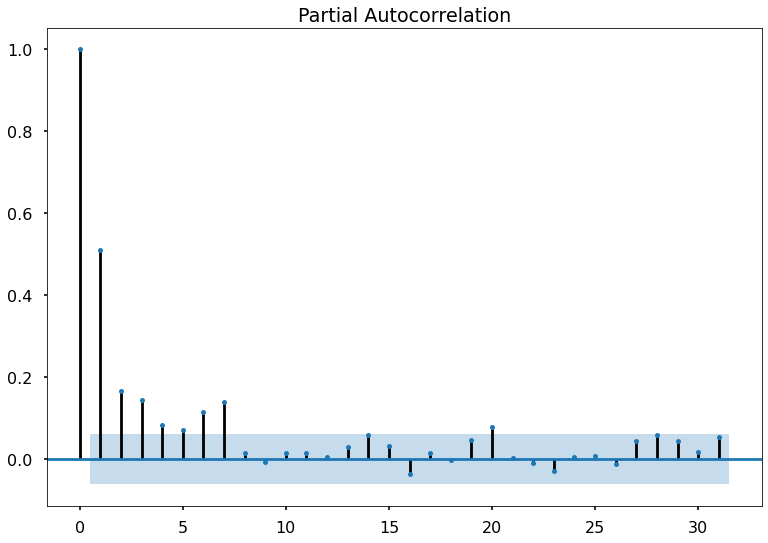

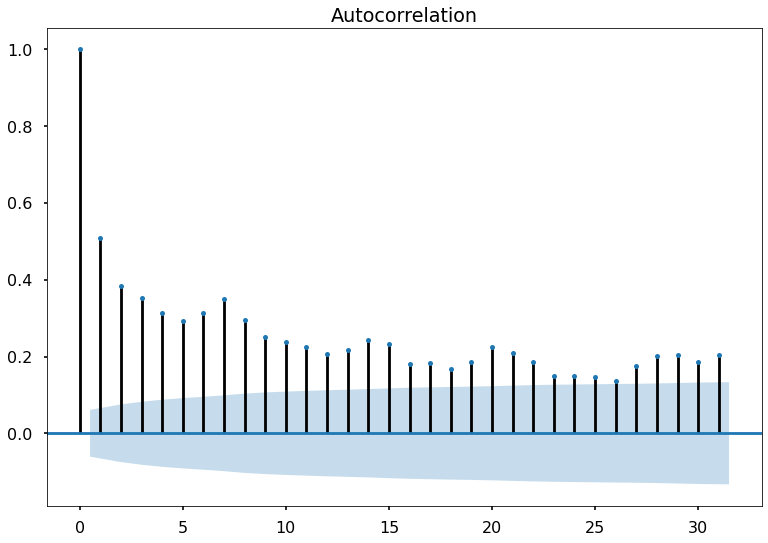

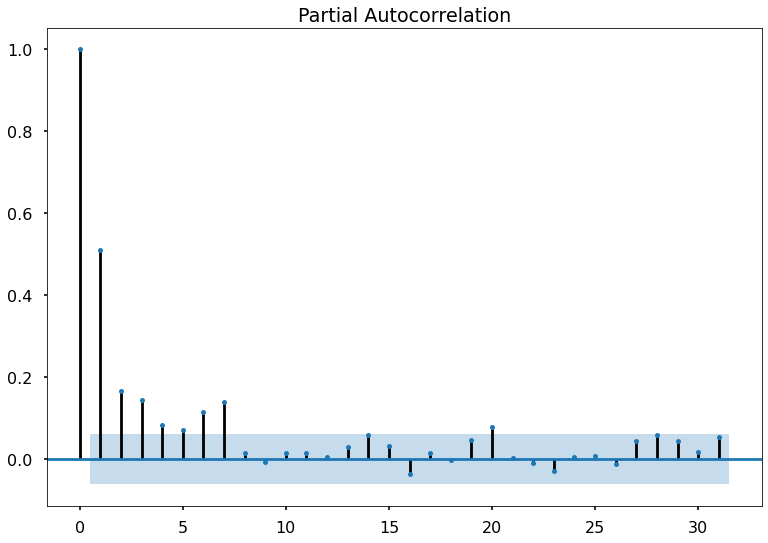

In [50]:
#plot autocorrelation and partial autocorrelation
#autocorrelation is a measure of the correlation between the lagged values of a time series
#partial autocorrelation is the correlation that results after removing the effect of any correlations due to the terms at shorter lags
plot_acf(all_data_by_day['total_sales'])
plot_pacf(all_data_by_day['total_sales'])

### 2.2 Rolling Window Features

Rolling window feature is to calculate statistical value base on past values. In this example, we are using the statistical of 7 days (1 week) to work on the rolling window. 

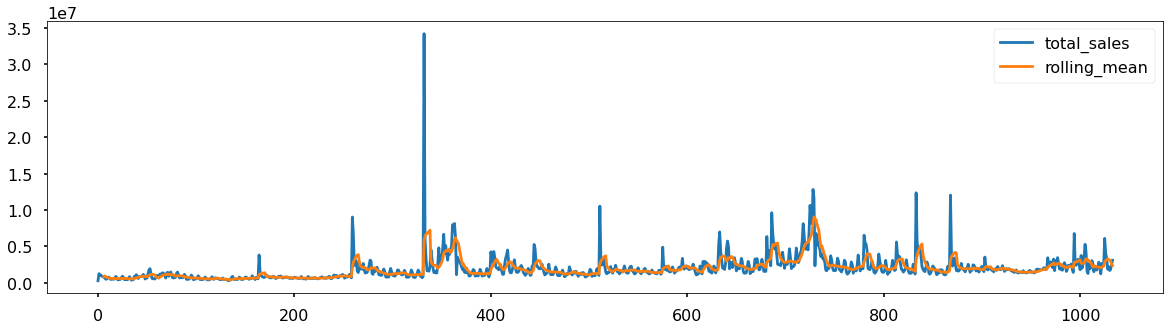

In [51]:
#construct the rolling mean of 7 days (1 week) compare with total sales
all_data_by_day['rolling_mean'] = all_data_by_day['total_sales'].rolling(window=7).mean()
all_data_by_day[['total_sales', 'rolling_mean']].plot(figsize=(20, 5))

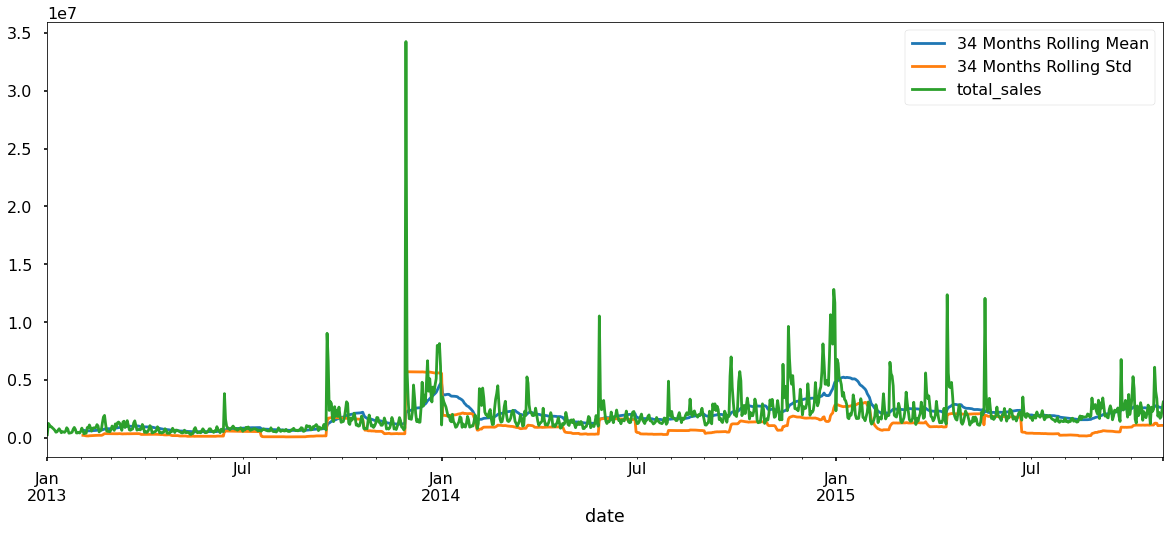

In [54]:
#construct the rolling mean and standard deviation of months compare with total sales
plt.rcParams['figure.figsize']=(20, 8)
all_data_by_day = all_data.groupby(['date']).agg(aggregations)
timeseries = all_data_by_day['total_sales']
timeseries.rolling(34).mean().plot(label='34 Months Rolling Mean')
timeseries.rolling(34).std().plot(label='34 Months Rolling Std')
timeseries.plot()
plt.legend()

### 2.3 Expanding Window Features
Expanding window feature is to take all the most recent values to calculate the mean. 7 days of mean is used in this calculation. 

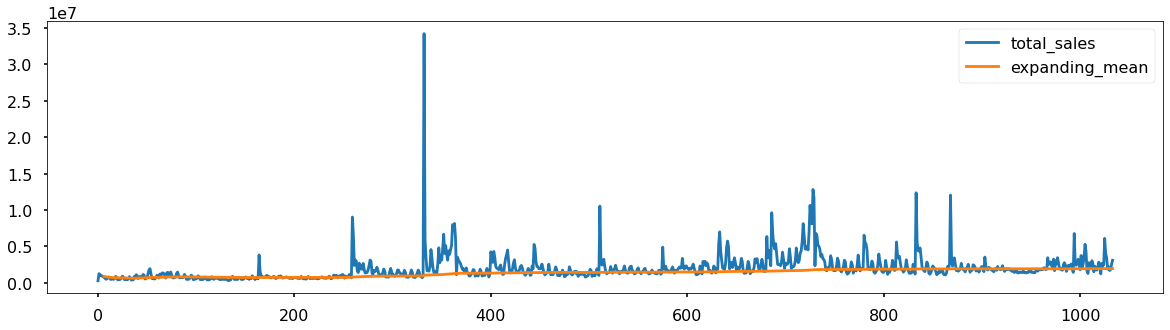

In [53]:
#construct the expanding mean of 7 days (1 week) compare with total sales
all_data_by_day['expanding_mean'] = all_data_by_day['total_sales'].expanding(7).mean()
all_data_by_day[['total_sales', 'expanding_mean']].plot(figsize=(20, 5))